In [1]:
# googledrive の使用
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install -U Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
1.0
-1.0
2019640/2019640 [==============================] - 0s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 1.7929 - accuracy: 0.2250
Epoch 1: val_loss improved from inf to 1.62900, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/mobilenetv2/model.h5
8/8 [==============================] - 14s 344ms/step - loss: 1.7929 - accuracy: 0.2250 - val_loss: 1.6290 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 1.2696 - accuracy: 0.4167
Epoch 2: val_loss improved from 1.62900 to 1.12878, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/mobilenetv2/model.h5
8/8 [==============================] - 2s 200ms/step - loss: 1.2696 - accuracy: 0.4167 - val_loss: 1.1288 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.6750
Epoch 3: val_loss improved from 1.12878 to 0.83352, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/mobilene

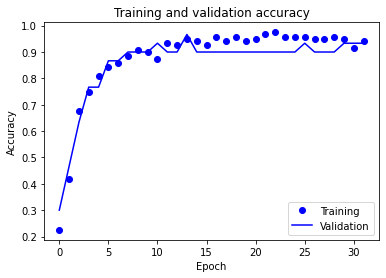

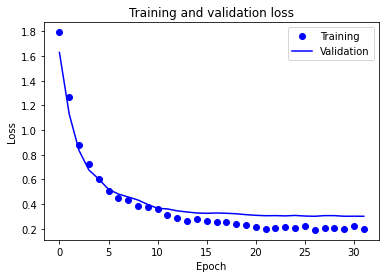

In [4]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import preprocess_input

data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/mobilenetv2'

IMAGE_SIZE = 224
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        alpha=0.35,  # alpha=0.35, 0.50, 0.75, 1.0, 1.3 or 1.4
    )
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False

        # Batch Normalization の freeze解除
        if layer.name.startswith('batch_normalization'):
            layer.trainable = True


    model.compile(
        loss="categorical_crossentropy",
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

# preprocess_input：画像の前処理
X = preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    zoom_range=0.2,
    #rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
151.061
-123.68
58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 2.6527 - accuracy: 0.3083
Epoch 1: val_loss improved from inf to 1.89053, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/vgg16/model.h5
8/8 [==============================] - 8s 737ms/step - loss: 2.6527 - accuracy: 0.3083 - val_loss: 1.8905 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 1.5604 - accuracy: 0.6083
Epoch 2: val_loss improved from 1.89053 to 1.00239, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/vgg16/model.h5
8/8 [==============================] - 2s 211ms/step - loss: 1.5604 - accuracy: 0.6083 - val_loss: 1.0024 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 0.9826 - accuracy: 0.6833
Epoch 3: val_loss improved from 1.00239 to 0.88953, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/vgg16/model.h5
8/8 [=

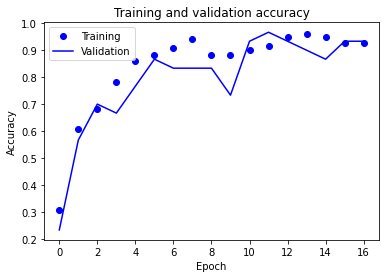

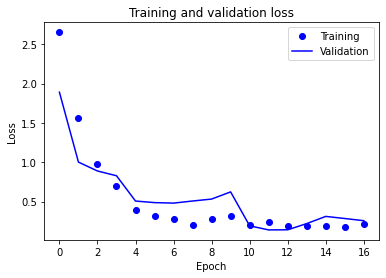

In [5]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input


data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/vgg16'

IMAGE_SIZE = 224
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss="categorical_crossentropy",
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

# preprocess_input：画像の前処理
X = preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    #rescale=1.0 / 255, # 画素値の正規化（0～255を0～1に）
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    zoom_range=0.2,
    #rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)

#valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
1.0
-1.0
83683744/83683744 [==============================] - 0s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 1.6113 - accuracy: 0.2000
Epoch 1: val_loss improved from inf to 1.71168, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/xception/model.h5
8/8 [==============================] - 11s 878ms/step - loss: 1.6113 - accuracy: 0.2000 - val_loss: 1.7117 - val_accuracy: 0.0667 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 1.5971 - accuracy: 0.2167
Epoch 2: val_loss improved from 1.71168 to 1.68471, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/xception/model.h5
8/8 [==============================] - 4s 481ms/step - loss: 1.5971 - accuracy: 0.2167 - val_loss: 1.6847 - val_accuracy: 0.0667 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 1.5752 - accuracy: 0.2333
Epoch 3: val_loss improved from 1.68471 to 1.64792, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/xception/model

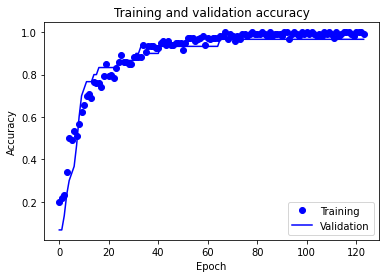

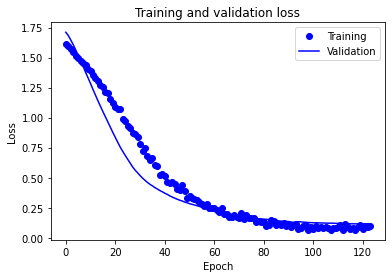

In [6]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import Xception
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.xception import preprocess_input

data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/xception'

IMAGE_SIZE = 299
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False
  
        # Batch Normalization の freeze解除
        if layer.name.startswith('batch_normalization'):
            layer.trainable = True


    model.compile(
        loss="categorical_crossentropy",
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

# preprocess_input：画像の前処理
X = preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    #rescale=1.0 / 255, # 画素値の正規化（0～255を0～1に）
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    #zoom_range=0.2,
    rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)

#valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
1.0
-1.0
219055592/219055592 [==============================] - 3s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 1.8055 - accuracy: 0.1583
Epoch 1: val_loss improved from inf to 1.55598, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/inceptionresnetv2/model.h5
8/8 [==============================] - 21s 1s/step - loss: 1.8055 - accuracy: 0.1583 - val_loss: 1.5560 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 1.4350 - accuracy: 0.3917
Epoch 2: val_loss improved from 1.55598 to 1.30035, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/inceptionresnetv2/model.h5
8/8 [==============================] - 5s 609ms/step - loss: 1.4350 - accuracy: 0.3917 - val_loss: 1.3004 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 1.2324 - accuracy: 0.5583
Epoch 3: val_loss improved from 1.30035 to 1.02714, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205

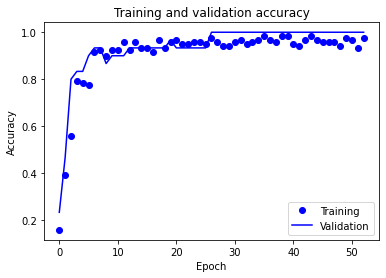

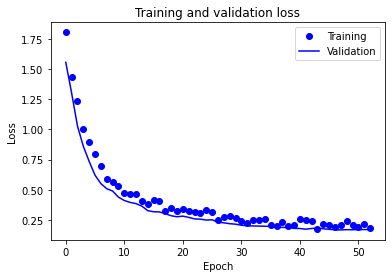

In [7]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import InceptionResNetV2
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.inception_resnet_v2 import preprocess_input

data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/inceptionresnetv2'

IMAGE_SIZE = 299
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss="categorical_crossentropy",
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

# preprocess_input：画像の前処理
X = preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    #rescale=1.0 / 255, # 画素値の正規化（0～255を0～1に）
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    zoom_range=0.2,
    #rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)

#valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
1.0
-1.0
94668760/94668760 [==============================] - 1s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 1.6681 - accuracy: 0.3000
Epoch 1: val_loss improved from inf to 0.96954, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/resnet50v2/model.h5
8/8 [==============================] - 8s 568ms/step - loss: 1.6681 - accuracy: 0.3000 - val_loss: 0.9695 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 0.9406 - accuracy: 0.6833
Epoch 2: val_loss improved from 0.96954 to 0.52736, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/resnet50v2/model.h5
8/8 [==============================] - 2s 258ms/step - loss: 0.9406 - accuracy: 0.6833 - val_loss: 0.5274 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.8083
Epoch 3: val_loss improved from 0.52736 to 0.39198, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/resnet50v2/

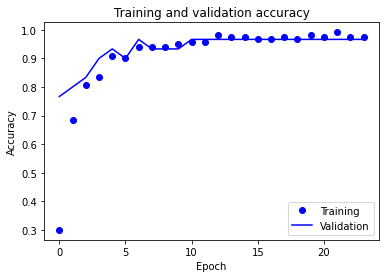

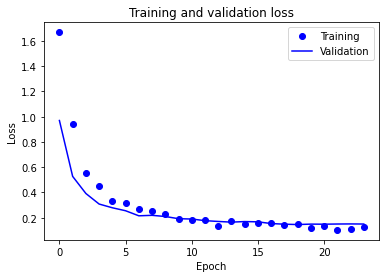

In [8]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import ResNet50V2
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.resnet_v2 import preprocess_input


data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/resnet50v2'

IMAGE_SIZE = 224
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = ResNet50V2(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss="categorical_crossentropy",
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

# preprocess_input：画像の前処理
X = preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    zoom_range=0.2,
    #rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)
valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
2.64
-2.117904
29084464/29084464 [==============================] - 0s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 1.7608 - accuracy: 0.2333
Epoch 1: val_loss improved from inf to 1.48715, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/densenet121/model.h5
8/8 [==============================] - 13s 835ms/step - loss: 1.7608 - accuracy: 0.2333 - val_loss: 1.4872 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 1.4184 - accuracy: 0.4083
Epoch 2: val_loss improved from 1.48715 to 1.13126, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/densenet121/model.h5
8/8 [==============================] - 2s 309ms/step - loss: 1.4184 - accuracy: 0.4083 - val_loss: 1.1313 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 1.0832 - accuracy: 0.6250
Epoch 3: val_loss improved from 1.13126 to 1.03128, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/densenet

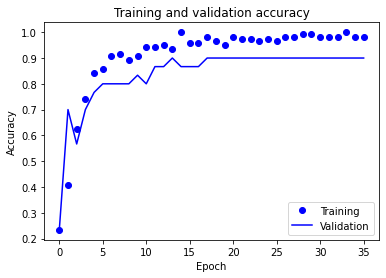

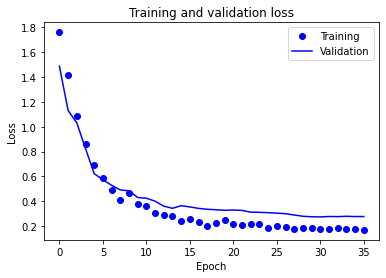

In [12]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import DenseNet121
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.densenet import preprocess_input


data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/densenet121'

IMAGE_SIZE = 224
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = DenseNet121(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss="categorical_crossentropy",
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

#preprocess_input：画像の前処理
X = preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    zoom_range=0.2,
    #rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
1.0
-1.0
19993432/19993432 [==============================] - 0s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 1.9151 - accuracy: 0.1083
Epoch 1: val_loss improved from inf to 1.75980, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/nasnetmobile/model.h5
8/8 [==============================] - 19s 1s/step - loss: 1.9151 - accuracy: 0.1083 - val_loss: 1.7598 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 1.6601 - accuracy: 0.2417
Epoch 2: val_loss improved from 1.75980 to 1.54087, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/nasnetmobile/model.h5
8/8 [==============================] - 4s 540ms/step - loss: 1.6601 - accuracy: 0.2417 - val_loss: 1.5409 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 1.3748 - accuracy: 0.4000
Epoch 3: val_loss improved from 1.54087 to 1.34490, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/nasnetmob

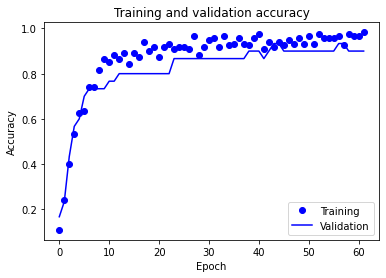

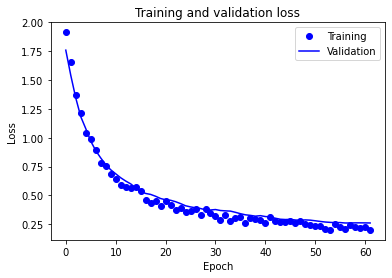

In [13]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import NASNetMobile
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.nasnet import preprocess_input

data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/nasnetmobile'

IMAGE_SIZE = 224
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = NASNetMobile(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss="categorical_crossentropy",
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

# preprocess_input：画像の前処理
X = preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    zoom_range=0.2,
    #rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


['Austenite', 'Ferrite', 'Ferrite_Perlite', 'Martensite', 'Perlite']
Xmax and Xmin before preprocess_input
255.0
0.0
Xmax and Xmin after preprocess_input
255.0
0.0
28456008/28456008 [==============================] - 0s 0us/step


Epoch 1/300
8/8 [==============================] - ETA: 0s - loss: 1.7168 - accuracy: 0.1583
Epoch 1: val_loss improved from inf to 1.69339, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/efficientnetv2b1/model.h5
8/8 [==============================] - 12s 594ms/step - loss: 1.7168 - accuracy: 0.1583 - val_loss: 1.6934 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 1.5559 - accuracy: 0.3000
Epoch 2: val_loss improved from 1.69339 to 1.44591, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_230205/efficientnetv2b1/model.h5
8/8 [==============================] - 2s 253ms/step - loss: 1.5559 - accuracy: 0.3000 - val_loss: 1.4459 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/300
8/8 [==============================] - ETA: 0s - loss: 1.3747 - accuracy: 0.4167
Epoch 3: val_loss improved from 1.44591 to 1.22727, saving model to /content/gdrive/My Drive/Colab Notebooks/metallography_23020

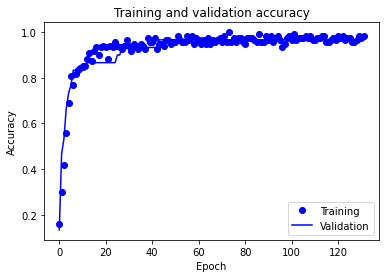

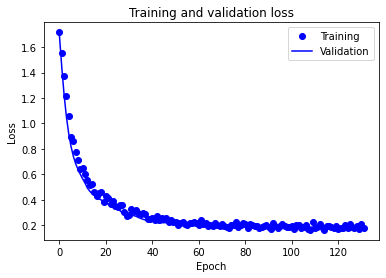

In [16]:
import glob
import os

import numpy as np
from keras.utils import to_categorical
from keras.applications import EfficientNetV2B1
from keras.callbacks import (CSVLogger, EarlyStopping, ModelCheckpoint,
                             ReduceLROnPlateau)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

data_path = '/content/gdrive/My Drive/Colab Notebooks/metallography'
output_path = '/content/gdrive/My Drive/Colab Notebooks/metallography_230205/efficientnetv2b1'

IMAGE_SIZE = 224
BATCH_SIZE = 16
NB_EPOCH = 300
VALID_SIZE = 0.2

# モデルの構築
def build_model():

    base_model = EfficientNetV2B1(
        weights="imagenet",
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # ベースモデル部分は再学習しない（転移学習）
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss="categorical_crossentropy",
        #optimizer=SGD(learning_rate=5e-4, momentum=0.9),
        optimizer=SGD(learning_rate=1e-3, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


labels = os.listdir(data_path)
nb_classes = len(labels)

labels.sort()
print(labels)

with open(output_path + "/labels.txt", "w") as o:
    for i, label in enumerate(labels):
        print(i, label, file=o)

X = []
y = []

for index, name in enumerate(labels):
    data_dir = data_path + "/" + name
    data_files = glob.glob(data_dir + "/*.*")
    for i, data_file in enumerate(data_files):

        image = Image.open(data_file)
        image = image.convert("RGB")

        im = ImageOps.fit(
            image,
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.Resampling.LANCZOS,  # Pillow 9.1.0で追加
        )

        data = np.asarray(im)
        X.append(data)
        y.append(index)

X = np.array(X)
y = np.array(y)

X = X.astype("float32")

# preprocess_input 前のXの最大値と最小値の表示
print("Xmax and Xmin before preprocess_input")
print(X.max())
print(X.min())

# preprocess_input：画像の前処理
X = tf.keras.applications.efficientnet.preprocess_input(X)

# preprocess_input 後のXの最大値と最小値の表示
print("Xmax and Xmin after preprocess_input")
print(X.max())
print(X.min())

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALID_SIZE, random_state=1
)

y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)

# インスタンスの呼び出し
model = build_model()

train_datagen = ImageDataGenerator(
    # 水増しのパラメータは、学習データと検証データの正解率をみながら適宜変更する
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    zoom_range=0.2,
    #rotation_range=20,
    #channel_shift_range=20,
    #brightness_range=[0.80, 1.0],
    # horizontal_flip=True,
    # vertical_flip=True,
)

train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator()
valid_datagen.fit(X_valid)

ResultFileName = output_path + "/" + "model"

# 学習経過の記録
csv_log = CSVLogger(ResultFileName + ".csv")

# モデルの学習が進まなくなったら学習終了
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# モデルの学習が遅くなってきたら学習率を小さくする
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

modelCheckpoint = ModelCheckpoint(
    filepath=ResultFileName + ".h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    period=1,
)

# モデルの学習
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=NB_EPOCH,
    validation_steps=1,
    verbose=1,
    validation_data=valid_datagen.flow(X_valid, y_valid),
    callbacks=[csv_log, early_stopping, reduce_lr, modelCheckpoint],
)

# 学習結果のグラフ表示
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "bo", label="Training")
plt.plot(epochs, val_acc, "b", label="Validation")
plt.title("Training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
